##ドライブにマウント

In [ ]:
# Google ColabでGoogle Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Decision Tree (データは自分のMyDriveにもショートカットを追加した)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, f1_score
from sklearn.impute import SimpleImputer

# ==========================================
# 1. データの読み込み
# ==========================================
file_path = '/content/drive/MyDrive/Team-Based-Project/data/train_test_2025.csv'

try:
    df = pd.read_csv(file_path, encoding='shift_jis')
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='cp932')
df['id'] = df.index
print("Original Shape:", df.shape)
display(df)




Original Shape: (10000, 16)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,ｙ,id
0,27,Private,294451,11th,7,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,United-States,no,0
1,38,Private,191137,10th,6,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,United-States,no,1
2,34,Private,66561,Bachelors,13,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,37,United-States,no,2
3,56,Self-emp-not-inc,32855,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,no,3
4,24,Private,378546,11th,7,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,39,United-States,no,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,41,Private,208613,Some-college,10,Never-married,Sales,Not-in-family,White,Male,0,0,40,United-States,no,9995
9996,37,Private,472517,Assoc-voc,11,Divorced,Other-service,Not-in-family,White,Female,0,0,4,United-States,no,9996
9997,38,Local-gov,189614,Some-college,10,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,40,United-States,no,9997
9998,52,Private,288353,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,99999,0,48,United-States,yes,9998


In [ ]:
# ==========================================
# 2. 前処理 (LightGBMとは異なるアプローチ)
# ==========================================

# (1) 不要な列の削除（ここは共通）
cols_to_drop = ['education', 'fnlwgt']
existing_drop_cols = [c for c in cols_to_drop if c in df.columns]
if existing_drop_cols:
    df = df.drop(existing_drop_cols, axis=1)

# (2) 目的変数の変換
target_col = 'ｙ'  # 全角ｙ
if target_col in df.columns:
    df['target'] = df[target_col].map({'yes': 1, 'no': 0})
    df = df.drop(target_col, axis=1)

# (3) 欠損値の補完 (Decision Tree用)
# 数値データは「中央値」、カテゴリデータは「最頻値」で埋める
# これにより、LightGBMが欠損として扱うデータも、決定木では「ある値」として扱われる
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('target')
cat_cols = df.select_dtypes(include=['object']).columns

# 数値の補完
imputer_num = SimpleImputer(strategy='median')
df[num_cols] = imputer_num.fit_transform(df[num_cols])

# カテゴリの補完
imputer_cat = SimpleImputer(strategy='most_frequent')
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

# (4) カテゴリ変数のOne-Hot Encoding
# LightGBMはLabel Encoding的に扱うが、決定木ではOne-Hotが一般的
# drop_first=Trueにすることで多重共線性を避けるが、木モデルならFalseでもOK（今回はTrueでシンプルに）
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print("\nPreprocessed Shape:", df.shape)
display(df)


Preprocessed Shape: (10000, 81)


,age,education-num,capital-gain,capital-loss,hours-per-week,id,target,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,27.0,7.0,0.0,0.0,40.0,0.0,0,False,True,False,...,False,False,False,False,False,False,False,True,False,False
1,38.0,6.0,0.0,0.0,40.0,1.0,0,False,True,False,...,False,False,False,False,False,False,False,True,False,False
2,34.0,13.0,0.0,0.0,37.0,2.0,0,False,True,False,...,False,False,False,False,False,False,False,True,False,False
3,56.0,10.0,0.0,0.0,50.0,3.0,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,24.0,7.0,0.0,0.0,39.0,4.0,0,False,True,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,41.0,10.0,0.0,0.0,40.0,9995.0,0,False,True,False,...,False,False,False,False,False,False,False,True,False,False
9996,37.0,11.0,0.0,0.0,4.0,9996.0,0,False,True,False,...,False,False,False,False,False,False,False,True,False,False
9997,38.0,10.0,0.0,0.0,40.0,9997.0,0,True,False,False,...,False,False,False,False,False,False,False,True,False,False
9998,52.0,13.0,99999.0,0.0,48.0,9998.0,1,False,True,False,...,False,False,False,False,False,False,False,True,False,False



--- Grid Search Training Start ---
Fitting 5 folds for each of 160 candidates, totalling 800 fits

Best Params: {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 50}
Best CV AUC: 0.8924

Test AUC Score: 0.9089


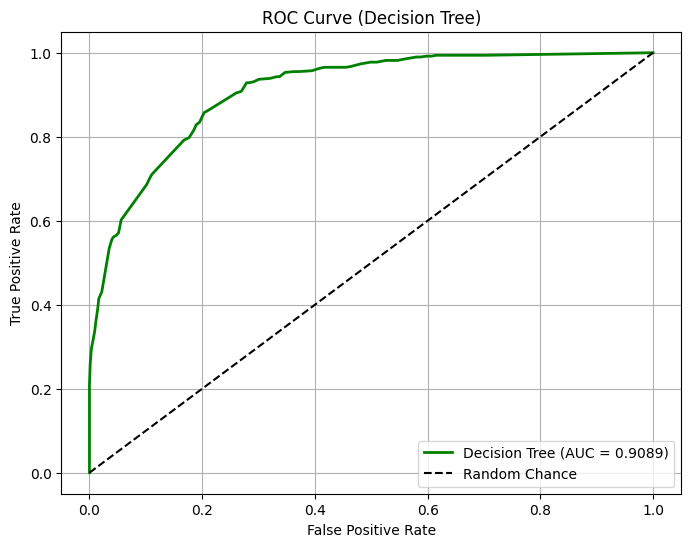


★ Optimized Threshold: 0.36 (Max F1: 0.6925)


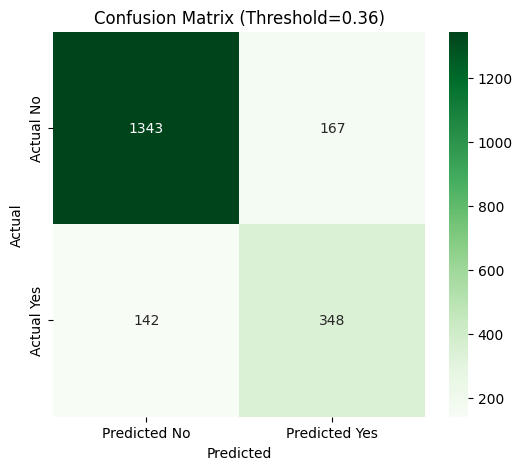


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1510
           1       0.68      0.71      0.69       490

    accuracy                           0.85      2000
   macro avg       0.79      0.80      0.79      2000
weighted avg       0.85      0.85      0.85      2000



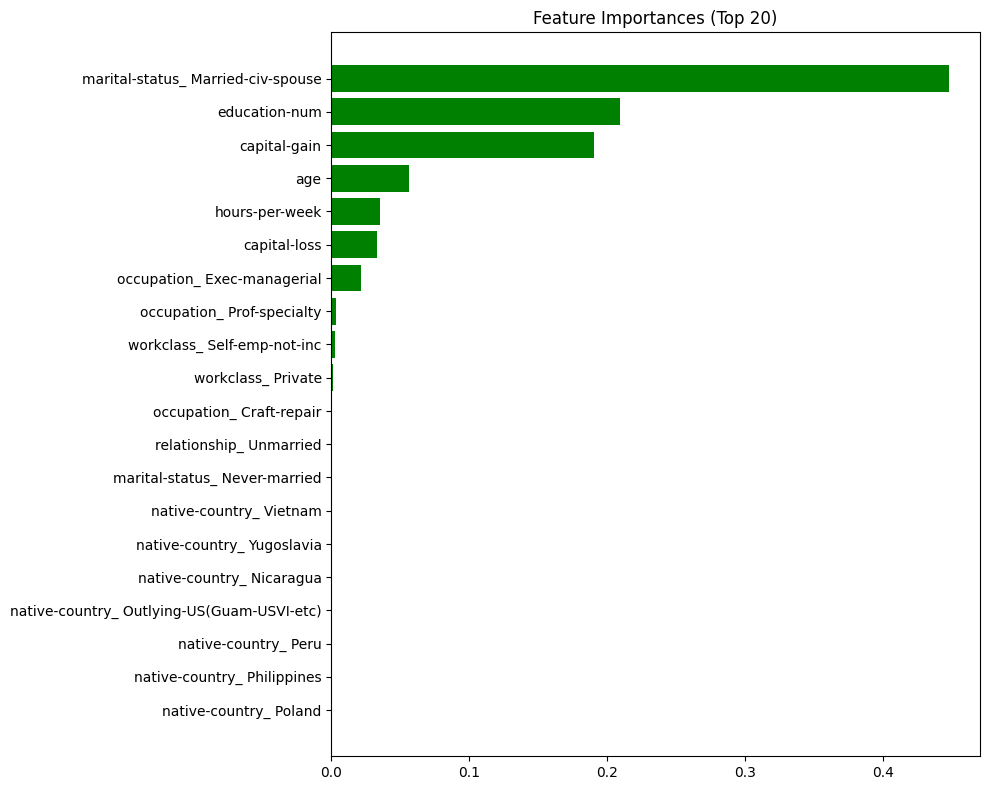

In [ ]:
# ==========================================
# 3. データ分割
# ==========================================
X = df.drop(['target', 'id'], axis=1)
y = df['target']
ids = df['id']

# LightGBMコードと同じ比率で分割（比較のため）
X_train, X_val, y_train, y_val, id_train, id_val = train_test_split(
    X, y, ids,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# ==========================================
# 4. モデル構築 & ハイパーパラメータ探索
# ==========================================
# 決定木は過学習しやすいモデル。
# GridSearchCVを使って「木の深さ」や「枝刈り(ccp_alpha)」を最適化し、汎化性能を高める。

param_grid = {
    'max_depth': [5, 7, 10, 15, None],           # 木の深さ
    'min_samples_leaf': [5, 10, 20, 50],         # 葉に含まれる最小サンプル数
    'criterion': ['gini', 'entropy'],            # 分割基準
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01]       # コスト複雑度枝刈り（過学習抑制）
}

dt = DecisionTreeClassifier(random_state=42)

# スコアリングはAUCで行う
grid_search = GridSearchCV(
    dt,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("\n--- Grid Search Training Start ---")
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("\nBest Params:", grid_search.best_params_)
print(f"Best CV AUC: {grid_search.best_score_:.4f}")

# ==========================================
# 5. 評価
# ==========================================
y_pred_prob = best_model.predict_proba(X_val)[:, 1]

# (A) AUCスコア
test_auc = roc_auc_score(y_val, y_pred_prob)
print(f"\n========================================")
print(f"Test AUC Score: {test_auc:.4f}")
print(f"========================================")

# (B) ROC曲線
fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {test_auc:.4f})', color='green', lw=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Decision Tree)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# (C) 閾値の最適化 (F1スコア最大化)
best_threshold = 0.5
best_f1 = 0
thresholds_range = np.arange(0.1, 0.9, 0.01)

for th in thresholds_range:
    y_pred_bin = (y_pred_prob >= th).astype(int)
    f1 = f1_score(y_val, y_pred_bin)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = th

print(f"\n★ Optimized Threshold: {best_threshold:.2f} (Max F1: {best_f1:.4f})")

# (D) 混同行列
y_pred_final = (y_pred_prob >= best_threshold).astype(int)
cm = confusion_matrix(y_val, y_pred_final)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title(f'Confusion Matrix (Threshold={best_threshold:.2f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\nClassification Report:")
print(classification_report(y_val, y_pred_final))

# (E) 特徴量重要度の可視化 (上位20個)
# One-Hot Encodingしているため特徴量数が多くなっている
importances = best_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(10, 8))
plt.title("Feature Importances (Top 20)")
plt.barh(range(len(indices)), importances[indices], align="center", color='green')
plt.yticks(range(len(indices)), feature_names[indices])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## データ出力してマイPCにダウンロードし、outputフォルダにアップロードした


In [ ]:
# ==========================================
# 8. 検証データ(Valid)の出力【修正版】
# ==========================================

# 1. 予測確率の取得（閾値適用前）
# すでに計算済みの y_pred_prob を使う
# y_pred_prob = best_model.predict_proba(X_val)[:, 1]

# 2. DataFrame作成
# アンサンブルに必須なのは 'id', 'Actual', 'Probability' の3つ
df_valid_output = pd.DataFrame({
    'id': id_val,                    # ID（結合時のキー）
    'Actual': y_val,                 # 正解ラベル
    'DT_Probability': y_pred_prob,   # ★重要: 生の確率（アンサンブルで使用）
    'DT_Prediction': (y_pred_prob >= best_threshold).astype(int) # 参考: 単体での予測結果(0/1)
})

# 3. 保存
valid_output_path = '/content/valid_prediction_dt.csv'
df_valid_output.to_csv(valid_output_path, index=False)

print(f"検証用データを保存した: {valid_output_path}")
print(df_valid_output.head())

検証用データを保存した: /content/valid_prediction_dt.csv
          id  Actual  DT_Probability  DT_Prediction
7013  7013.0       0        0.356818              0
2477  2477.0       1        0.435556              1
8228  8228.0       0        0.000000              0
6678  6678.0       1        0.000000              0
3488  3488.0       1        0.241379              0


In [ ]:
# ==========================================
# 9. 提出用データ(submit)の予測と出力
# ==========================================

# 1. データの読み込み
submit_file_path = '/content/drive/MyDrive/Team-Based-Project/data/submit_2025.csv'  # アップロードしたパスに合わせて変更
try:
    df_submit = pd.read_csv(submit_file_path, encoding='shift_jis')
except UnicodeDecodeError:
    df_submit = pd.read_csv(submit_file_path, encoding='cp932')

# 【重要】ID列の作成（0から始まる連番を付与）
df_submit['id'] = df_submit.index
submit_ids = df_submit['id']  # 出力用に保持

# 2. 前処理 (学習データと同じ処理を適用)
# (1) 不要列の削除 (yや既存のscore列があれば削除)
cols_to_exclude = ['ｙ', 'probability of yes (or score)', 'education', 'fnlwgt']
df_submit_processed = df_submit.drop([c for c in cols_to_exclude if c in df_submit.columns], axis=1)

# (3) 欠損値補完 (学習済みのimputerを使用)
# fit_transformではなく、transformを使うのが鉄則
df_submit_processed[num_cols] = imputer_num.transform(df_submit_processed[num_cols])
df_submit_processed[cat_cols] = imputer_cat.transform(df_submit_processed[cat_cols])

# (4) ダミー変数化
df_submit_processed = pd.get_dummies(df_submit_processed, columns=cat_cols, drop_first=True)

# (5) カラム合わせ (学習データX_trainと列を完全に一致させる)
# 足りない列は0埋め、余分な列は削除
df_submit_processed = df_submit_processed.reindex(columns=X_train.columns, fill_value=0)

# 3. 予測の実行
# 確率 (Probability)
submit_probs = best_model.predict_proba(df_submit_processed)[:, 1]

# 4. 検証データと同じ形式でDataFrame作成
# Actual列は正解がないため作成しない
df_submit_output = pd.DataFrame({
    'id': submit_ids,
    'DT_Probability': submit_probs,
    'DT_Prediction': (submit_probs >= best_threshold).astype(int) # 閾値0.36での予測(参考用)
})

# 5. 保存
submit_output_path = '/content/test_prediction_dt.csv'
df_submit_output.to_csv(submit_output_path, index=False)

print(f"提出用予測データを保存した: {submit_output_path}")
print(df_submit_output.head())

提出用予測データを保存した: /content/test_prediction_dt.csv
   id  DT_Probability  DT_Prediction
0   0        0.375000              1
1   1        0.452381              1
2   2        0.015873              0
3   3        0.015873              0
4   4        0.159091              0
